# Predicting the next word

In [4]:
#import paskages 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
#Load data
file_path ='data/sonnets.txt'

with open(file_path) as f:
    data= f.read()

#convert text to lower as return as a list
corpus= data.lower().split("\n")

print(len(corpus))

2159


In [14]:
for i in  range(5):
    print(corpus[i])

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


#### Tokenizer Text

In [28]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words=len(tokenizer.word_index)+1
print(f"Total words is a {total_words}")

Total words is a 3211


In [29]:
corpus[0]

'from fairest creatures we desire increase,'

If you pass this text directly into the texts_to_sequences method you will get an unexpected result:

In [30]:
tokenizer.texts_to_sequences(corpus[0])

[[],
 [],
 [58],
 [],
 [],
 [],
 [17],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 []]

This happened because texts_to_sequences expects a list and you are providing a string. However a string is still and iterable in Python so you will get the word index of every character in the string.

In [31]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

In [32]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the n_gram sequences for each line in the corpus:

In [35]:
def n_gram_seqs(corpus , tokenizer):
    
    input_sequences= []
    
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        
        for i in range(1, len(token_list)):
            input_sequences.append(token_list[:i+1])
            
    return input_sequences
    

In [37]:
first_example_sequence = n_gram_seqs([corpus[0]] , tokenizer)

first_example_sequence

[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [38]:
second_examples_sequence = n_gram_seqs([corpus[1]] , tokenizer)
second_examples_sequence


[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199]]

Apply the n_gram_seqs transformation to the whole corpus and save the maximum sequence length to use it later:

In [39]:
input_sequences = n_gram_seqs(corpus , tokenizer)

max_sequence_len = max([len(x) for x in input_sequences])

print(max_sequence_len)

11


In [40]:
len(input_sequences)

15462

### Add padding to the sequences

In [42]:
def pad_seqs(input_sequences , maxlen):
    padded_sequences = pad_sequences(input_sequences , maxlen=maxlen ,padding='pre')
    
    return padded_sequences

In [44]:
first_padded_seq = pad_seqs(first_example_sequence , max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]])

In [46]:
# Pad the whole corpus
input_sequences=pad_seqs(input_sequences , max_sequence_len)
input_sequences.shape

(15462, 11)

#### Split the data into features and labels

In [47]:
def features_and_labels(input_sequences , total_words):
    
    features= input_sequences[:,:-1]
    labels=input_sequences[:,-1]
    one_hot_labels= tf.keras.utils.to_categorical(labels  , num_classes=total_words)
    
    return features , one_hot_labels

In [48]:
first_features , first_labels = features_and_labels(first_padded_seq , total_words)

first_features

array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]])

In [49]:
features , labels = features_and_labels(input_sequences , total_words)

In [50]:
features

array([[   0,    0,    0, ...,    0,    0,   34],
       [   0,    0,    0, ...,    0,   34,  417],
       [   0,    0,    0, ...,   34,  417,  877],
       ...,
       [   0,    0,    0, ..., 3209,  493,  493],
       [   0,    0,    0, ...,  493,  493, 3210],
       [   0,    0,    0, ...,  493, 3210,   15]])

In [51]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [52]:
print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


### Create the model

In [63]:
def create_model(total_words , max_sequence_len):
    model=tf.keras.Sequential([
        tf.keras.layers.Embedding(total_words ,100 , input_length=max_sequence_len-1),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(total_words , activation='softmax')
            ])
    
    model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])
    
    return model

In [59]:
model= create_model(total_words , max_sequence_len)
history=model.fit(features ,labels , epochs=50 ,verbose=1)

Epoch 1/50
484/484 [==============================] - 19s 32ms/step - loss: 6.8759 - accuracy: 0.0226
Epoch 2/50
484/484 [==============================] - 21s 43ms/step - loss: 6.4272 - accuracy: 0.0336
Epoch 3/50
484/484 [==============================] - 18s 38ms/step - loss: 6.1983 - accuracy: 0.0407
Epoch 4/50
484/484 [==============================] - 17s 34ms/step - loss: 5.9491 - accuracy: 0.0499
Epoch 5/50
484/484 [==============================] - 17s 35ms/step - loss: 5.6785 - accuracy: 0.0607
Epoch 6/50
484/484 [==============================] - 18s 38ms/step - loss: 5.3591 - accuracy: 0.0724
Epoch 7/50
484/484 [==============================] - 17s 34ms/step - loss: 5.0115 - accuracy: 0.0900
Epoch 8/50
484/484 [==============================] - 16s 32ms/step - loss: 4.6439 - accuracy: 0.1116
Epoch 9/50
484/484 [==============================] - 15s 31ms/step - loss: 4.2744 - accuracy: 0.1471
Epoch 10/50
484/484 [==============================] - 15s 31ms/step - loss: 3.918

In [72]:
def plot_graph(history ,string):
    plt.plot(history.history[string])    
    plt.xlabel("Epochs")
    plt.ylabel(string)    
    plt.show()

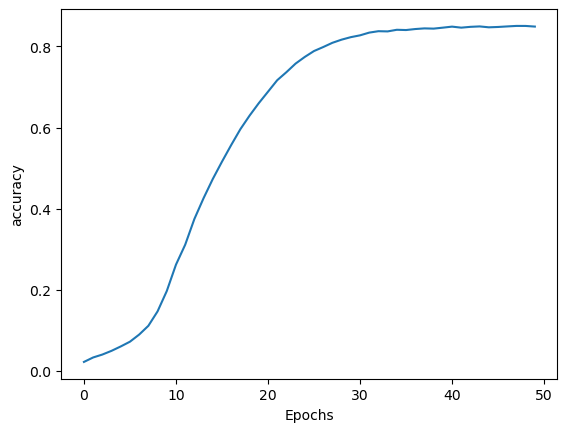

In [71]:
plot_graph(history, "accuracy")

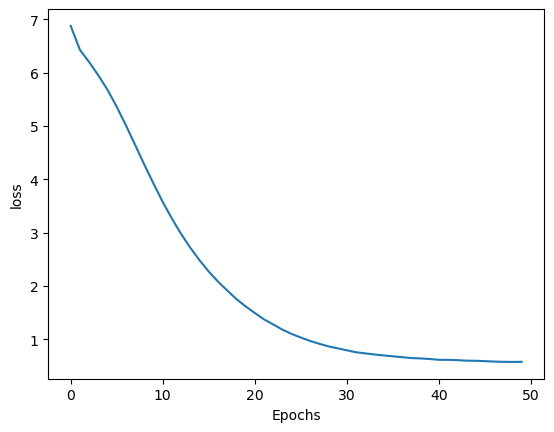

In [74]:
plot_graph(history, "loss")